In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:

MARGIN = 5  # pixels
FONT_SIZE = 0.5
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks

  print(hand_landmarks_list)
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Xử lý dữ liệu

In [3]:
import mediapipe as mp
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

base_options = python.BaseOptions(model_asset_buffer=open('hand_landmarker.task', "rb").read())
options = vision.HandLandmarkerOptions(base_options=base_options, 
                                       running_mode=vision.RunningMode.IMAGE,
                                       num_hands=1,
                                       min_hand_detection_confidence=0.3,
                                       min_hand_presence_confidence=0.3)
lmker = vision.HandLandmarker.create_from_options(options)

DIR_FIRST_DATASET = 'dataset/asl_alphabet_train' # https://www.kaggle.com/datasets/grassknoted/asl-alphabet
DIR_SECOND_DATASET = 'dataset/asl_gesture_data'  # https://www.kaggle.com/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset

def process_image_cv2(img_path: str, debug=False):
    # Load the image
    image = cv2.imread(img_path)

    # Convert to hsv
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # increase the V channel by 30, but dont apply with white pixels
    image[..., 2] = np.where(image[..., 2] > 210, image[..., 2], image[..., 2] + 30)

    # Convert image to RGB for Mediapipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb


def process_image(img_path: str, label = str, debug=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    equalized = process_image_cv2(img_path, debug)
    # equalized = img

    mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=equalized)
    
    detection_results = lmker.detect(mp_img)

    if debug:
        annotated_image = draw_landmarks_on_image(mp_img.numpy_view(), detection_results)
        cv2.imshow('', cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(0)

    hand_landmarks_list = detection_results.hand_landmarks

    if len(hand_landmarks_list) == 0:
        if debug:
            print(f'No hands detected in {img_path}')
        return (None, 1)
    
    hand_landmarks = hand_landmarks_list[0]
    handedness = (detection_results.handedness[0])[0].category_name

    # Add handedness and label (assuming label is available)
    new_row = {
        'label': ord(label) - ord('A'),
        'handedness': True if handedness == 'Right' else False
    }
    new_row.update({f'landmark_{i}_x': landmark.x for (i, landmark) in enumerate(hand_landmarks)})
    new_row.update({f'landmark_{i}_y': landmark.y for (i, landmark) in enumerate(hand_landmarks)})
    new_row.update({f'landmark_{i}_z': landmark.z for (i, landmark) in enumerate(hand_landmarks)})

    # Append new row efficiently
    new_row_df = pd.DataFrame([new_row])
    total_distance = 0
    for i in range(1, 21):
        total_distance += np.sqrt((new_row_df[f'landmark_{i}_x'][0] - new_row_df[f'landmark_{i-1}_x'][0])**2 +
                                    (new_row_df[f'landmark_{i}_y'][0] - new_row_df[f'landmark_{i-1}_y'][0])**2 +
                                    (new_row_df[f'landmark_{i}_z'][0] - new_row_df[f'landmark_{i-1}_z'][0])**2)
    if debug:
        print(total_distance)
    if total_distance < 1.3:
        if debug:
            print(f'False detection {img_path}', end='\r')
        
        return (None, 2)

    return (new_row_df, 0)

process_image('dataset/asl_alphabet_train/F/F123.jpg', 'F', debug=True)


[[NormalizedLandmark(x=0.6182772517204285, y=0.7463011741638184, z=1.5144688632062753e-06, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.747462272644043, y=0.6310034990310669, z=-0.04836048185825348, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8255029916763306, y=0.5234647989273071, z=-0.06958719342947006, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8655986785888672, y=0.41398727893829346, z=-0.0908675268292427, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8745973706245422, y=0.3102099597454071, z=-0.1097322553396225, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6577359437942505, y=0.406320184469223, z=-0.005790157709270716, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7003793120384216, y=0.30520594120025635, z=-0.05745749548077583, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7736037373542786, y=0.2888760268688202, z=-0.10183605551719666, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8441165685653687, y=0.29068708

(   label  handedness  landmark_0_x  landmark_1_x  landmark_2_x  landmark_3_x  \
 0      5        True      0.618277      0.747462      0.825503      0.865599   
 
    landmark_4_x  landmark_5_x  landmark_6_x  landmark_7_x  ...  landmark_11_z  \
 0      0.874597      0.657736      0.700379      0.773604  ...      -0.097223   
 
    landmark_12_z  landmark_13_z  landmark_14_z  landmark_15_z  landmark_16_z  \
 0      -0.126136      -0.036585      -0.085344      -0.127693      -0.156044   
 
    landmark_17_z  landmark_18_z  landmark_19_z  landmark_20_z  
 0      -0.063278       -0.10457      -0.131638      -0.151714  
 
 [1 rows x 65 columns],
 0)

In [29]:
columns = ['label', 'handedness'] + [f'landmark_{i}_x' for i in range(21)] + [f'landmark_{i}_y' for i in range(21)] + [f'landmark_{i}_z' for i in range(21)]

features_mediapipe_original = pd.DataFrame(columns=columns)

# df set type, label and handedness = int8, landmarks = float16
features_mediapipe_original = features_mediapipe_original.astype({'label': 'int8', 'handedness': 'boolean'})
for i in range(21):
    features_mediapipe_original = features_mediapipe_original.astype({f'landmark_{i}_x': 'float16', f'landmark_{i}_y': 'float16'})

for label in os.listdir(DIR_FIRST_DATASET):
    cnt = 0
    success_cnt = 0
    failed_cnt_1 = 0
    failed_cnt_2 = 0

    for img in os.listdir(os.path.join(DIR_FIRST_DATASET, label)):
        cnt += 1
        if cnt % 20 == 0:
            print(f'[Char = {label}] [Img = {cnt}: {success_cnt}/{failed_cnt_1}/{failed_cnt_2}] Processing {img}...', end='\r')
        
        res = process_image(os.path.join(DIR_FIRST_DATASET, label, img), label)
        new_row_df = res[0]
        if res[1] == 1:
            failed_cnt_1 += 1
            continue
        elif res[1] == 2:
            failed_cnt_2 += 1
            continue
        
        success_cnt += 1
        features_mediapipe_original = pd.concat([features_mediapipe_original, new_row_df], ignore_index=True)
    
    print(f'\n{cnt} images processed for label {label}, success: {success_cnt}, failed: {failed_cnt_1 + failed_cnt_2}')

print('\n', features_mediapipe_original.shape)

C:\Users\Loli\AppData\Local\Temp\ipykernel_5440\1560341316.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_mediapipe_original = pd.concat([features_mediapipe_original, new_row_df], ignore_index=True)


[Char = -] [Img = 3000: 1937/942/120] Processing del999.jpg....
3000 images processed for label -, success: 1937, failed: 1063
[Char = A] [Img = 3000: 2482/428/89] Processing A999.jpg....
3000 images processed for label A, success: 2483, failed: 517
[Char = B] [Img = 3000: 2611/317/71] Processing B999.jpg....
3000 images processed for label B, success: 2612, failed: 388
[Char = C] [Img = 3000: 2384/593/22] Processing C999.jpg....
3000 images processed for label C, success: 2384, failed: 616
[Char = D] [Img = 3000: 2805/187/7] Processing D999.jpg....
3000 images processed for label D, success: 2806, failed: 194
[Char = E] [Img = 3000: 2328/475/196] Processing E999.jpg....
3000 images processed for label E, success: 2329, failed: 671
[Char = F] [Img = 3000: 2976/21/2] Processing F999.jpg....
3000 images processed for label F, success: 2977, failed: 23
[Char = G] [Img = 3000: 2735/186/78] Processing G999.jpg....
3000 images processed for label G, success: 2736, failed: 264
[Char = H] [Img

In [30]:
features_mediapipe_original.to_pickle('features_mediapipe_original_xyz.pkl')
features_mediapipe_original.to_csv('features_mediapipe_original_xyz.csv', index=False)

In [31]:
features_mediapipe_original_d2 = pd.DataFrame(columns=columns)

# df set type, label and handedness = int8, landmarks = float16
features_mediapipe_original_d2 = features_mediapipe_original_d2.astype({'label': 'int8', 'handedness': 'boolean'})
for i in range(21):
    features_mediapipe_original_d2 = features_mediapipe_original_d2.astype({f'landmark_{i}_x': 'float16', f'landmark_{i}_y': 'float16'})

for label in os.listdir(DIR_SECOND_DATASET):
    cnt = 0
    success_cnt = 0
    failed_cnt_1 = 0
    failed_cnt_2 = 0

    for img in os.listdir(os.path.join(DIR_SECOND_DATASET, label)):
        cnt += 1
        if cnt % 20 == 0:
            print(f'[Char = {label}] [Img = {cnt}: {success_cnt}/{failed_cnt_1}/{failed_cnt_2}] Processing {img}...', end='\r')
        
        res = process_image(os.path.join(DIR_SECOND_DATASET, label, img), label)
        new_row_df = res[0]
        if res[1] == 1:
            failed_cnt_1 += 1
            continue
        elif res[1] == 2:
            failed_cnt_2 += 1
            continue
        
        success_cnt += 1
        features_mediapipe_original_d2 = pd.concat([features_mediapipe_original_d2, new_row_df], ignore_index=True)
    
    print(f'\n{cnt} images processed for label {label}, success: {success_cnt}, failed: {failed_cnt_1 + failed_cnt_2}')

print('\n', features_mediapipe_original_d2.shape)

C:\Users\Loli\AppData\Local\Temp\ipykernel_5440\1605344031.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_mediapipe_original_d2 = pd.concat([features_mediapipe_original_d2, new_row_df], ignore_index=True)


[Char = A] [Img = 1500: 879/450/170] Processing 999.jpg...
1500 images processed for label A, success: 880, failed: 620
[Char = B] [Img = 1500: 1499/0/0] Processing 999.jpg...
1500 images processed for label B, success: 1500, failed: 0
[Char = C] [Img = 1500: 1482/14/3] Processing 999.jpg...
1500 images processed for label C, success: 1483, failed: 17
[Char = D] [Img = 1500: 1499/0/0] Processing 999.jpg...
1500 images processed for label D, success: 1500, failed: 0
[Char = E] [Img = 1500: 265/1162/72] Processing 999.jpg...
1500 images processed for label E, success: 265, failed: 1235
[Char = F] [Img = 1500: 1499/0/0] Processing 999.jpg...
1500 images processed for label F, success: 1500, failed: 0
[Char = G] [Img = 1500: 1498/1/0] Processing 999.jpg...
1500 images processed for label G, success: 1499, failed: 1
[Char = H] [Img = 1500: 1499/0/0] Processing 999.jpg...
1500 images processed for label H, success: 1500, failed: 0
[Char = I] [Img = 1500: 1437/62/0] Processing 999.jpg...
1500

In [32]:
features_mediapipe_original_d2.to_pickle('features_mediapipe_original_d2_xyz.pkl')
features_mediapipe_original_d2.to_csv('features_mediapipe_original_d2_xyz.csv', index=False)

In [33]:
features_mediapipe_original = pd.read_pickle('features_mediapipe_original_xyz.pkl')
features_mediapipe_original_d2 = pd.read_pickle('features_mediapipe_original_d2_xyz.pkl')

# merge the two datasets
features_mediapipe_original = pd.concat([features_mediapipe_original, features_mediapipe_original_d2], ignore_index=True)

# count the number of samples for each label
features_mediapipe_original['label'].value_counts()

label
 5     4477
 3     4306
 11    4285
 10    4279
 7     4277
 6     4235
 17    4171
 1     4112
 21    4104
 20    4082
 22    4062
 9     3927
 8     3915
 2     3867
 16    3728
 15    3725
 25    3713
 24    3465
 23    3430
 0     3363
 13    2744
 14    2606
 4     2594
 30    2418
 18    2389
 19    2276
 12    2141
-20    1937
Name: count, dtype: int64

In [36]:
# clean the dataset
def check_total_distance(new_row_df: pd.DataFrame):
    total_distance = 0
    for i in range(1, 21):
        total_distance += np.sqrt((new_row_df[f'landmark_{i}_x'][0] - new_row_df[f'landmark_{i-1}_x'][0])**2 +
                                    (new_row_df[f'landmark_{i}_y'][0] - new_row_df[f'landmark_{i-1}_y'][0])**2 +
                                    (new_row_df[f'landmark_{i}_z'][0] - new_row_df[f'landmark_{i-1}_z'][0])**2)
    if total_distance < 1.3:
        return False
    return True

columns = ['label', 'handedness'] + [f'landmark_{i}_x' for i in range(21)] + [f'landmark_{i}_y' for i in range(21)] + [f'landmark_{i}_z' for i in range(21)]

char_cnt = {}
features_mediapipe_merged_cleaned = pd.DataFrame(columns=columns)
features_mediapipe_merged_cleaned = features_mediapipe_merged_cleaned.astype({'label': 'int8', 'handedness': 'boolean'})
for i in range(21):
    features_mediapipe_merged_cleaned = features_mediapipe_merged_cleaned.astype({f'landmark_{i}_x': 'float16', f'landmark_{i}_y': 'float16', f'landmark_{i}_z': 'float16'})


# check all row in features_mediapipe_original, if check_total_distance return True, append to features_mediapipe_merged_cleaned
for i in range(features_mediapipe_original.shape[0]):
    if i % 100 == 0:
        print(f'Processing {i}...', end='\r')
    new_row_df = pd.concat([features_mediapipe_original.iloc[[i]]], ignore_index=True)
    # print(new_row_df['label'][0])
    if check_total_distance(new_row_df):
        features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, new_row_df], ignore_index=True)
    else:
        if new_row_df['label'][0] in char_cnt:
            char_cnt[new_row_df['label'][0]] += 1
        else:
            char_cnt[new_row_df['label'][0]] = 1

print('\n', features_mediapipe_merged_cleaned.shape)
print(char_cnt)

features_mediapipe_merged_cleaned.to_pickle('features_mediapipe_merged_cleaned_xyz.pkl')
features_mediapipe_merged_cleaned.to_csv('features_mediapipe_merged_cleaned_xyz.csv', index=False)


Processing 98600...
 (98628, 65)
{}


In [4]:
import pickle
features_mediapipe_merged_cleaned = pd.read_pickle('features_mediapipe_merged_cleaned_xyz.pkl')

features_mediapipe_merged_cleaned['label'].value_counts()

label
 5     4477
 3     4306
 11    4285
 10    4279
 7     4277
 6     4235
 17    4171
 1     4112
 21    4104
 20    4082
 22    4062
 9     3927
 8     3915
 2     3867
 16    3728
 15    3725
 25    3713
 24    3465
 23    3430
 0     3363
 13    2744
 14    2606
 4     2594
 30    2418
 18    2389
 19    2276
 12    2141
-20    1937
Name: count, dtype: int64

In [ ]:
features_mp_add_autocmp = pd.read_csv('hand_sign_new_data_autocmp.csv')
features_mp_add_h = pd.read_csv('hand_sign_new_data_h.csv')
features_mp_add_m = pd.read_csv('hand_sign_new_data_m.csv')
features_mp_add_s = pd.read_csv('hand_sign_new_data_s.csv')
features_mp_add_t = pd.read_csv('hand_sign_new_data_t.csv')

features_mp_add_autocmp = features_mp_add_autocmp.astype({'label': 'int8', 'handedness': 'boolean'})
features_mp_add_h = features_mp_add_h.astype({'label': 'int8', 'handedness': 'boolean'})
features_mp_add_m = features_mp_add_m.astype({'label': 'int8', 'handedness': 'boolean'})
features_mp_add_s = features_mp_add_s.astype({'label': 'int8', 'handedness': 'boolean'})
features_mp_add_t = features_mp_add_t.astype({'label': 'int8', 'handedness': 'boolean'})

features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, features_mp_add_autocmp], ignore_index=True)
features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, features_mp_add_h], ignore_index=True)
features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, features_mp_add_m], ignore_index=True)
features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, features_mp_add_s], ignore_index=True)
features_mediapipe_merged_cleaned = pd.concat([features_mediapipe_merged_cleaned, features_mp_add_t], ignore_index=True)


features_mediapipe_merged_cleaned.to_pickle('features_mediapipe_merged_v2_xyz.pkl')
features_mediapipe_merged_cleaned.to_csv('features_mediapipe_merged_v2_xyz.csv', index=False)




In [6]:
features_mediapipe_merged_cleaned['label'].value_counts()

label
 7     6293
 5     4477
 3     4306
 11    4285
 10    4279
 6     4235
 17    4171
 1     4112
 21    4104
 20    4082
 22    4062
 9     3927
 8     3915
 2     3867
 16    3728
 15    3725
 25    3713
 18    3589
 24    3465
 23    3430
 0     3363
 19    3308
 12    3229
 28    3000
 13    2744
 14    2606
 4     2594
 30    2418
-20    1937
Name: count, dtype: int64

# RF

In [7]:

# shuffle the dataset
data_pd = features_mediapipe_merged_cleaned.sample(frac=1, random_state=42)

# take 2120 samples for each label
data_pd = data_pd.groupby('label').head(2590)

# count the number of samples for each label
data_pd['label'].value_counts()



label
 1     2590
 21    2590
 28    2590
 9     2590
 14    2590
 5     2590
 16    2590
 2     2590
 20    2590
 17    2590
 18    2590
 22    2590
 10    2590
 4     2590
 7     2590
 3     2590
 23    2590
 25    2590
 13    2590
 11    2590
 19    2590
 15    2590
 6     2590
 8     2590
 24    2590
 0     2590
 12    2590
 30    2418
-20    1937
Name: count, dtype: int64

In [8]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# split the dataset into training and testing
X = data_pd.drop(columns=['label', 'handedness'])
y = data_pd['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.995) 
X_pca = pca.fit_transform(X_scaled)

pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(pca, open('pca.pkl', 'wb'))

print(f"Original feature shape: {X.shape}")
print(f"Reduced feature shape after PCA: {X_pca.shape}")

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(y_train.value_counts())
print(X_test.shape, y_test.shape)
print(y_test.value_counts())


Original feature shape: (74285, 63)
Reduced feature shape after PCA: (74285, 22)
(59428, 22) (59428,)
label
 13    2072
 10    2072
 8     2072
 17    2072
 14    2072
 21    2072
 5     2072
 3     2072
 4     2072
 24    2072
 1     2072
 7     2072
 20    2072
 28    2072
 18    2072
 2     2072
 15    2072
 11    2072
 22    2072
 19    2072
 0     2072
 6     2072
 25    2072
 23    2072
 12    2072
 16    2072
 9     2072
 30    1934
-20    1550
Name: count, dtype: int64
(14857, 22) (14857,)
label
 14    518
 11    518
 7     518
 9     518
 25    518
 2     518
 1     518
 3     518
 13    518
 16    518
 20    518
 12    518
 6     518
 10    518
 8     518
 17    518
 21    518
 19    518
 18    518
 4     518
 0     518
 22    518
 24    518
 28    518
 23    518
 5     518
 15    518
 30    484
-20    387
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import cross_validate

scoring = ["accuracy"]                              # Tiêu chí đánh giá
rf = RandomForestClassifier(n_jobs=-1)              # Khởi tạo model Random Forest
cv_res = cross_validate(rf, X_train, y_train, scoring=scoring)  # Cross validation
print(f"General accuracy: {cv_res["test_accuracy"].mean()}")


General accuracy: 0.987110456361093


In [10]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 7), round(std * 2, 7), params))

In [11]:
# Tinh chỉnh tham số sử dụng GridSearchCV
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

parameters = {
    'n_estimators': [100, 125, 150, 175],          # Số cây
    'max_features': ['log2'],      # Số features tối đa mỗi cây
    'max_depth': [13, 15, 18, 20]                 # Độ sâu tối đa mỗi cây
}

cv = GridSearchCV(rf, parameters, n_jobs=-1)  # Thử với model Random Forest
cv.fit(X_train,y_train.values.ravel())        # Fit với dữ liệu train
print_results(cv)                             # Hàm phụ trợ in kết quả

BEST PARAMS: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 175}

0.9800936 (+/-0.0017082) for {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 100}
0.9799589 (+/-0.0015695) for {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 125}
0.9803459 (+/-0.0018706) for {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 150}
0.9798916 (+/-0.0017234) for {'max_depth': 13, 'max_features': 'log2', 'n_estimators': 175}
0.9837955 (+/-0.0017508) for {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 100}
0.9842162 (+/-0.0015947) for {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 125}
0.9843508 (+/-0.0015963) for {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 150}
0.98462 (+/-0.0023997) for {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 175}
0.9865383 (+/-0.0013956) for {'max_depth': 18, 'max_features': 'log2', 'n_estimators': 100}
0.9866898 (+/-0.0009598) for {'max_depth': 18, 'max_features': 'log2', 'n_estimators': 125}
0.986

In [12]:
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


def print_results_each(mdl: RandomForestClassifier, time, test_pred, test_set):
    bal_acc = balanced_accuracy_score(test_set,test_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(test_set, test_pred, average='weighted')
    print('MAX FEATURES: {} / NUMBER OF EST: {} -- Time: {} / Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(mdl.max_features,
                                                                         mdl.n_estimators,
                                                                         round(time,7),
                                                                         round(bal_acc,7),
                                                                         round(precision,7),
                                                                         round(recall,7),
                                                                         round(f1,7)))
# confusion matrix
def print_confusion_matrix(test_pred, test_set):
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(test_set, test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [13]:
import time

rf1 = RandomForestClassifier(n_estimators=125, max_features = 'log2', max_depth=13, n_jobs=-1)
rf2 = RandomForestClassifier(n_estimators=125, max_features = 'log2', max_depth=15, n_jobs=-1)
rf3 = RandomForestClassifier(n_estimators=150, max_features = 'log2', max_depth=13, n_jobs=-1)

for model in [rf1,rf2,rf3]:                         # Thử từng model
    start = time.time()                             # Bắt đầu đếm thời gian
    model.fit(X_train, y_train)                     # Fit với tập train
    y_pred = model.predict(X_test)                   # Dự đoán tập validation
    end = time.time()                               # Kết thúc đếm thời gian
    print_results_each(model, time = end-start, test_pred=y_pred, test_set=y_test)     # Hàm phụ trợ in kết quả

MAX FEATURES: log2 / NUMBER OF EST: 125 -- Time: 6.0625815 / Acc: 0.984585 / Precision: 0.9846431 / Recall: 0.9845191 / F1: 0.9845252
MAX FEATURES: log2 / NUMBER OF EST: 125 -- Time: 6.2830606 / Acc: 0.9866533 / Precision: 0.9866908 / Recall: 0.9866056 / F1: 0.9866124
MAX FEATURES: log2 / NUMBER OF EST: 150 -- Time: 6.9997673 / Acc: 0.9832536 / Precision: 0.9833246 / Recall: 0.9831729 / F1: 0.9831863


MAX FEATURES: log2 / NUMBER OF EST: 125 -- Time: 0 / Acc: 0.9866533 / Precision: 0.9866908 / Recall: 0.9866056 / F1: 0.9866124
              precision    recall  f1-score   support

         -20       0.97      0.99      0.98       387
           0       0.98      0.99      0.99       518
           1       0.99      1.00      1.00       518
           2       0.99      0.99      0.99       518
           3       0.99      0.98      0.99       518
           4       1.00      0.97      0.99       518
           5       1.00      1.00      1.00       518
           6       1.00      0.99      0.99       518
           7       0.99      0.99      0.99       518
           8       1.00      0.99      1.00       518
           9       1.00      0.99      0.99       518
          10       1.00      1.00      1.00       518
          11       1.00      0.99      1.00       518
          12       0.95      0.97      0.96       518
          13       0.97      0.95      0.96       518
        

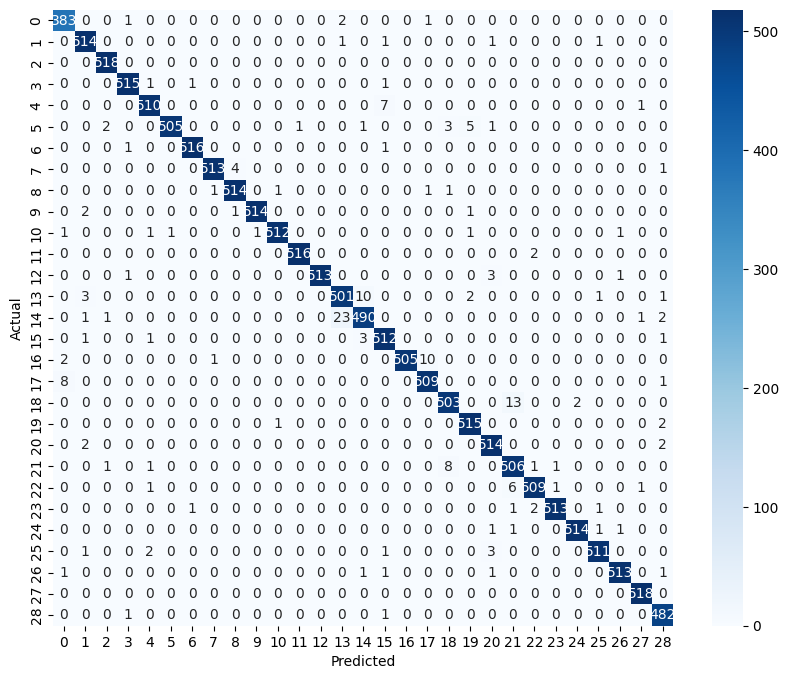

In [14]:
import pickle
mdl = rf2
pickle.dump(mdl, open('rf_model_pca.pkl', 'wb'))

# mdl = pickle.load(open('rf_model_pca.pkl', 'rb'))
y_pred = mdl.predict(X_test)
print_results_each(mdl, time = 0, test_pred=y_pred, test_set=y_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print_confusion_matrix(y_pred, y_test)


# Test

Original feature shape: (106964, 63)
Reduced feature shape after PCA: (106964, 22)
MAX FEATURES: log2 / NUMBER OF EST: 125 -- Time: 0 / Acc: 0.9937049 / Precision: 0.9936123 / Recall: 0.9935866 / F1: 0.9935897
              precision    recall  f1-score   support

         -20       0.99      1.00      0.99      1937
           0       0.99      1.00      0.99      3363
           1       1.00      1.00      1.00      4112
           2       1.00      1.00      1.00      3867
           3       1.00      0.99      0.99      4306
           4       1.00      0.99      0.99      2594
           5       1.00      1.00      1.00      4477
           6       0.99      0.99      0.99      4235
           7       1.00      0.99      0.99      6293
           8       1.00      0.99      1.00      3915
           9       1.00      0.99      1.00      3927
          10       1.00      1.00      1.00      4279
          11       1.00      1.00      1.00      4285
          12       0.98      0.99

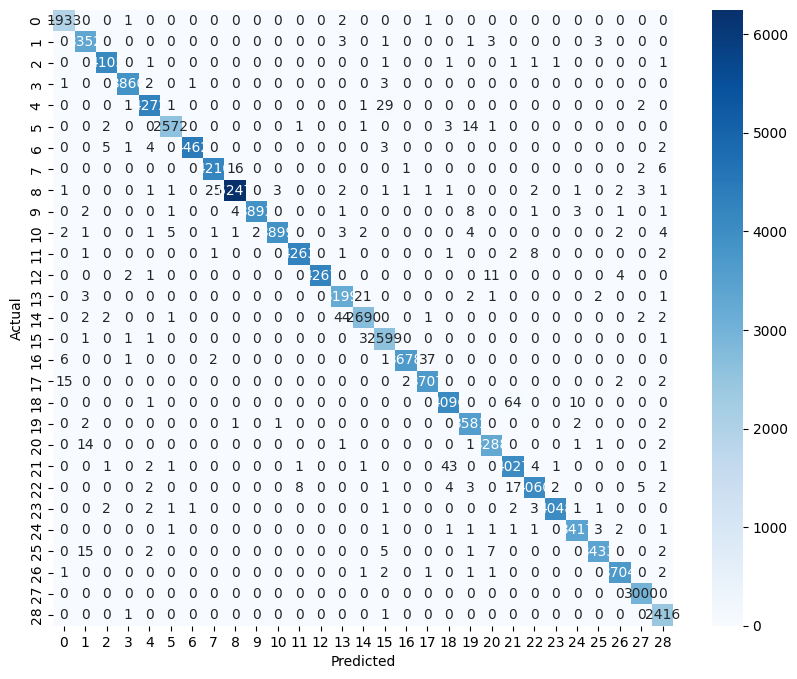

In [15]:
# test on all samples
features_mediapipe_merged_cleaned = pd.read_csv('features_mediapipe_merged_v2_xyz.csv')

X_lft = features_mediapipe_merged_cleaned.drop(columns=['label', 'handedness'])
y_lft = features_mediapipe_merged_cleaned['label']

# PCA

scaler = pickle.load(open('scaler.pkl', 'rb'))
X_scaled_lft = scaler.transform(X_lft)

pca = pickle.load(open('pca.pkl', 'rb'))
X_pca_lft = pca.transform(X_scaled_lft)

print(f"Original feature shape: {X_lft.shape}")
print(f"Reduced feature shape after PCA: {X_pca_lft.shape}")

mdl_try = pickle.load(open('rf_model_pca.pkl', 'rb'))
y_pred_lft = mdl_try.predict(X_pca_lft)
print_results_each(mdl_try, time = 0, test_pred=y_pred_lft, test_set=y_lft)
print(classification_report(y_lft, y_pred_lft))
print_confusion_matrix(y_pred_lft, y_lft)

In [19]:
import json


def to_json_object(x_input: pd.DataFrame):

    output_json_object = {"landmarks": []}
    for i in range(21):
        output_json_object["landmarks"].append({
            "x": x_input[f"landmark_{i}_x"].values[0],
            "y": x_input[f"landmark_{i}_y"].values[0],
            "z": x_input[f"landmark_{i}_z"].values[0]
        })
        
    return json.dumps(output_json_object)


In [20]:
def image_test(img_path: str, label: str):
    row = process_image(img_path, label, debug=True)[0]
    if row is None:
        return
    
    X_single = row.drop(columns=['label', 'handedness'])
    json_object_str = to_json_object(X_single)
    
    with open('json_object_str.json', 'w') as f:
        f.write(json_object_str)

    X_single_scaled = scaler.transform(X_single)
    X_single_pca = pca.transform(X_single_scaled)

    print(X_single_pca)
    pred_list = mdl_try.predict_proba(X_single_pca)
    y_single_pred = np.argmax(pred_list, axis=1)
    pred_char = ""
    if y_single_pred[0] == 0:
        pred_char = "delete"
    elif y_single_pred[0] == 27:
        pred_char = "space"
    else:
        pred_char = chr(y_single_pred[0] + ord("A") - 1)
    
    if label == pred_char:
        print(f'Correct prediction! Predicted: {pred_char}')
    else:
        print(f'Incorrect prediction! Predicted: {pred_char} Actual: {label}')
    
    # # Print all characters and their probabilities
    print(f'delete: {pred_list[0][0]}')
    print(f'space: {pred_list[0][27]}')
    for i in range(1, 27):
        print(f'{chr(i + ord("A") - 1)}: {pred_list[0][i]}')



In [21]:
import numpy as np
import pandas as pd

def input_array_test(list: list, label: str):
    X_single = np.array(list)
    X_single_scaled = scaler.transform(X_single)
    X_single_pca = pca.transform(X_single_scaled)

    print(X_single_pca)
    pred_list = mdl_try.predict_proba(X_single_pca)
    y_single_pred = np.argmax(pred_list, axis=1)
    pred_char = ""
    if y_single_pred[0] == 0:
        pred_char = "delete"
    elif y_single_pred[0] == 27:
        pred_char = "space"
    else:
        pred_char = chr(y_single_pred[0] + ord("A") - 1)
    
    if label == pred_char:
        print(f'Correct prediction! Predicted: {pred_char}')
    else:
        print(f'Incorrect prediction! Predicted: {pred_char} Actual: {label}')
    
    # # Print all characters and their probabilities
    print(f'delete: {pred_list[0][0]}')
    print(f'space: {pred_list[0][27]}')
    for i in range(1, 27):
        print(f'{chr(i + ord("A") - 1)}: {pred_list[0][i]}')

In [22]:
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

scaler: StandardScaler = pickle.load(open('scaler.pkl', 'rb'))
pca: PCA = pickle.load(open('pca.pkl', 'rb'))
mdl_try: RandomForestClassifier = pickle.load(open('rf_model_pca.pkl', 'rb'))

# for i in range(26):
#     image_test(f'dataset/asl_alphabet_test/{chr(i+65)}_test.jpg', chr(i+65))

# image_test('dataset/asl_alphabet_test/space_test.jpg', '_')

In [29]:
image_test('dataset/asl_alphabet_train/F/F123.jpg', 'F')

[[NormalizedLandmark(x=0.6182772517204285, y=0.7463011741638184, z=1.5144688632062753e-06, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.747462272644043, y=0.6310034990310669, z=-0.04836048185825348, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8255029916763306, y=0.5234647989273071, z=-0.06958719342947006, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8655986785888672, y=0.41398727893829346, z=-0.0908675268292427, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8745973706245422, y=0.3102099597454071, z=-0.1097322553396225, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6577359437942505, y=0.406320184469223, z=-0.005790157709270716, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7003793120384216, y=0.30520594120025635, z=-0.05745749548077583, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7736037373542786, y=0.2888760268688202, z=-0.10183605551719666, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8441165685653687, y=0.29068708

In [4]:
x_input = [[0.46506932, 0.5673108, 0.6146883, 0.5988295, 0.52522403, 0.5670886, 0.58538723, 0.5949424, 0.5940366, 0.5052191, 0.5421544, 0.59467155, 0.62957895, 0.43425384, 0.4988721, 0.5324819, 0.5295688, 0.3711862, 0.46229196, 0.50085974, 0.50035214, 0.96138644, 0.90181184, 0.73435205, 0.5952459, 0.5143259, 0.62394226, 0.46498606, 0.36383924, 0.27791882, 0.61102164, 0.43478802, 0.34119374, 0.25939864, 0.6207669, 0.50806534, 0.6175792, 0.7009959, 0.6424121, 0.5863017, 0.66742945, 0.7325335]]

input_array_test(x_input,
                 'R')

Correct prediction! Predicted: R
delete: 0.0
space: 0.005
A: 0.0
B: 0.005
C: 0.0
D: 0.015
E: 0.0
F: 0.01
G: 0.015
H: 0.005
I: 0.0
J: 0.005
K: 0.01
L: 0.0
M: 0.0
N: 0.015
O: 0.0
P: 0.005
Q: 0.0
R: 0.81
S: 0.0
T: 0.005
U: 0.055
V: 0.015
W: 0.0
X: 0.015
Y: 0.01
Z: 0.0


c:\Users\Loli\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
